In [1]:
# Imports
import numpy as np
from utility import load_fmri, load_phenotype

In [ ]:
from ssm.plots import gradient_cmap, white_to_color_cmap

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [2]:
# Load the data
data_root = "/home/calesella/projects/brainhack/data/fMRI_timeseries_clean_denoised_GSR_parcellated"
file_filter = "*task-hammer*.h5"
data, subjects = load_fmri(data_root, file_filter)

No files found matching *task-hammer*.h5 in NDAR_INVBL062HTE
No files found matching *task-hammer*.h5 in NDAR_INVBY805EE5
No files found matching *task-hammer*.h5 in NDAR_INVGB371PPV
No files found matching *task-hammer*.h5 in NDAR_INVGT021UPR
No files found matching *task-hammer*.h5 in NDAR_INVHA329EL1
No files found matching *task-hammer*.h5 in NDAR_INVLL260KC0
No files found matching *task-hammer*.h5 in NDAR_INVPF283TAQ
No files found matching *task-hammer*.h5 in NDAR_INVRR054KAM
No files found matching *task-hammer*.h5 in NDAR_INVUA181LXU
No files found matching *task-hammer*.h5 in NDAR_INVVU614ZKP
No files found matching *task-hammer*.h5 in NDAR_INVXR625UBQ
No files found matching *task-hammer*.h5 in NDAR_INVXV404VJL
No files found matching *task-hammer*.h5 in NDAR_INVYT858CBN
No files found matching *task-hammer*.h5 in NDAR_INVZH090MNG
No files found matching *task-hammer*.h5 in NDAR_INVZU586UPF


In [3]:
data = np.array( [array for array in data if array.shape[1]==493] )  # Filter the data for subject that completed the task

In [4]:
bold_data_zsc = np.array([
        (bold_sub - np.mean(bold_sub, axis=1, keepdims=True)) / np.std(bold_sub, axis=1, keepdims=True)
        for bold_sub in data
    ])

In [5]:
bold_data_zsc.shape

(219, 434, 493)

In [6]:
concatenated_data = bold_data_zsc.transpose(1, 0, 2)
concatenated_data = concatenated_data.reshape(434, -1)
concatenated_data.shape

(434, 107967)

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
compressed_data = pca.fit_transform(concatenated_data.T)
compressed_data.shape

(107967, 50)

In [8]:
import ssm
T = compressed_data.shape[0]  # number of time bins
K = 5    # number of discrete states
D = compressed_data.shape[1]    # dimension of the observations

# make an hmm and sample from it
hmm = ssm.HSMM(K, D, observations="gaussian")
hmm_lls = hmm.fit(compressed_data, method="em", init_method="kmeans")

/home/calesella/miniconda3/envs/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/calesella/miniconda3/envs/myenv/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
LP: -9966175.7:   0%|          | 0/100 [00:00<?, ?it/s]/home/calesella/miniconda3/envs/myenv/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
LP: -9966175.7:   0%|          | 0/100 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [9]:
import matplotlib.pyplot as plt
plt.plot(hmm_lls, label="EM")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

NameError: name 'hmm_lls' is not defined

Text(0.5, 0, 'time')

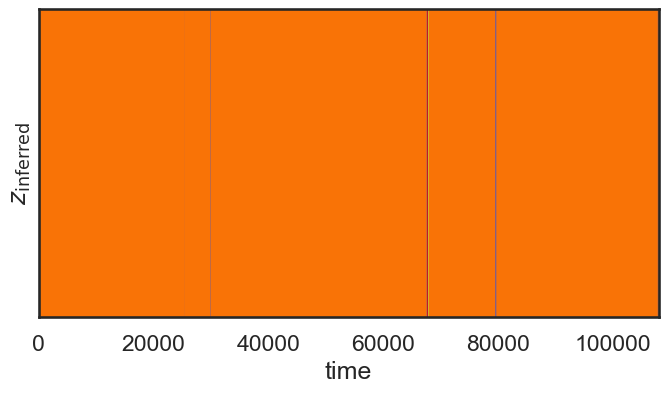

In [16]:
# Plot the true and inferred discrete states
hmm_z = hmm.most_likely_states(compressed_data)

plt.figure(figsize=(8, 4))
plt.imshow(hmm_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

In [7]:
import ssm
T = concatenated_data[1]  # number of time bins
K = 3    # number of discrete states
D = concatenated_data.shape[0]    # dimension of the observations

# make an hmm and sample from it
hmm = ssm.HMM(K, D, observations="gaussian")
hmm_lls = hmm.fit(concatenated_data.T, method="em", num_iters=50, init_method="kmeans")

/home/calesella/miniconda3/envs/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


: 

: 

: 

# Backup code

In [2]:
data_root = "/home/calesella/projects/brainhack/data/phenotype"
phenotype = load_phenotype(data_root)

In [6]:
df = phenotype

# Step 1: Identify duplicated column names
duplicated_columns = df.columns[df.columns.duplicated()].tolist()

if duplicated_columns:
    print(f"Duplicated columns found: {duplicated_columns}")
    
    # Step 2: Count how many times each column is duplicated
    duplicate_counts = {col: (df.columns == col).sum() for col in set(duplicated_columns)}
    print("Duplicate counts for each column:")
    for col, count in duplicate_counts.items():
        print(f"Column '{col}' is duplicated {count} times.")
    
    # Step 3: Check if all duplicates are identical
    for col in set(duplicated_columns):
        # Select all occurrences of the duplicated column
        duplicate_data = df.loc[:, df.columns == col]
        
        # Check if all columns are identical
        are_identical = duplicate_data.nunique(axis=1).eq(1).all()
        
        if are_identical:
            print(f"All occurrences of column '{col}' are identical.")
        else:
            print(f"Occurrences of column '{col}' have different values.")
else:
    print("No duplicated columns found.")

Duplicated columns found: ['src_subject_id_src_subject_id', 'interview_date_src_subject_id', 'interview_age_src_subject_id', 'sex_src_subject_id', 'src_subject_id_src_subject_id', 'interview_date_src_subject_id', 'interview_age_src_subject_id', 'sex_src_subject_id', 'src_subject_id_src_subject_id', 'interview_date_src_subject_id', 'interview_age_src_subject_id', 'sex_src_subject_id', 'src_subject_id_src_subject_id', 'interview_date_src_subject_id', 'interview_age_src_subject_id', 'sex_src_subject_id', 'src_subject_id_src_subject_id', 'interview_date_src_subject_id', 'interview_age_src_subject_id', 'sex_src_subject_id', 'src_subject_id_src_subject_id', 'interview_date_src_subject_id', 'interview_age_src_subject_id', 'sex_src_subject_id', 'src_subject_id_src_subject_id', 'interview_date_src_subject_id', 'interview_age_src_subject_id', 'sex_src_subject_id', 'src_subject_id_src_subject_id', 'interview_date_src_subject_id', 'interview_age_src_subject_id', 'sex_src_subject_id', 'src_subject_

In [ ]:
from utility import load_definitions
data_root = "/home/calesella/projects/brainhack/data/phenotype"
definitions = load_definitions(data_root)

In [ ]:
# Filter the definitions dataframe to keep only rows where ElementName is a column in phenotype
filtered_definitions = definitions[definitions['ElementName'].isin(phenotype.columns)]
filtered_definitions.to_csv("/home/calesella/projects/brainhack/data/dataset_phenotypes_definitions.tsv", sep='\t')


In [ ]:
import pandas as pd
definitions.to_csv("/home/calesella/projects/brainhack/all_phenotypes_definitions.tsv", sep='\t')

In [ ]:
filtered_definitions.to_csv("/home/calesella/projects/brainhack/data/dataset_phenotypes_definitions.tsv", sep='\t')